# Lightning Strike Locations

This notebook walks through the retrieval of lightning strike data from the German site <a href="http://en.blitzortung.org/">blitzortung</a>

<br>

### Imports

In [1]:
## Data Manipulation
import pandas as pd
import numpy as np
import json

## Plotting
import matplotlib.pyplot as plt

## Spatial
import folium
import rasterio as rio
from rasterio.plot import show, plotting_extent
from shapely.geometry import Point
import geopandas as gpd

## Data Retrieval
import _thread as thread
import websocket

## Misc
import os
import time

## Display
from ipypb import track
from IPython.display import JSON

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)

<br>

### Data Retrieval

Accessing data through websockets is slightly more complex than the traditional approach of using post and get requests, the reason they're used is that they enable continuous connection between the client and the server.

We'll use the Python websocket-client module to communicate with the blitzortung server. With websocket-client you have to specify a number of functions which relate to websocket events, these include: 

* <i>on_open</i> -> What event should be fired when the websocket is opened
* <i>on_message</i> -> What to do when data is returned
* <i>on_error</i> -> What to do if the connection has an issue
* <i>on_close</i> -> What to when the connection is closed

We'll start by looking at what event shoudl be fired when the websocket is opened. Inspecting the <a href="https://map.blitzortung.org/JavaScript/index.js">javascript on the page</a> we can see an onopen function.

```javascript
ws.onopen = function() { 
    ws.send('{"time":0}'); 
    ws_sendTimer= setInterval(function(){ 
        ws.send('{}'); 
    }, 30000); 
};
```

We'll recreate the same functionality in Python except with a slightly extended interval length.

In [3]:
thread_run_time = 60*60 # seconds

def on_open(ws):
    def run(*args):
        start_time = pd.Timestamp.now()
        current_time = pd.Timestamp.now()
        
        while (current_time-start_time).total_seconds() < thread_run_time:
            ws.send('{"time":0}')
            current_time = pd.Timestamp.now()
            time.sleep(1)
            
        time.sleep(1)
            
        ws.close()
        print("thread terminating...")
        
    thread.start_new_thread(run, ())

<br>

Most importantly we need to tell our script what to do when it receives the strike data, for ease we'll save it as a JSON and include the datetime in the filename.

In [4]:
get_current_ts = lambda: pd.Timestamp.now().strftime('%y-%m-%d %H-%M-%S.%f')[:-4]

def on_message(ws, message):
    ts_str = get_current_ts()
    data_dir = 'data/json_responses'
    assert ts_str not in os.listdir(data_dir)
    
    with open(f'{data_dir}/{ts_str}.json', 'w') as fp:
        json.dump(json.loads(message), fp)

<br>

Finally we need to specify the on_error and on_close functions, thankfully these are a lot simpler.

In [5]:
def on_error(ws, error):
    print(error)

def on_close(ws):
    print("### closed ###")

<br>

Nowe we've prepared our websocket functions we need to specify the url. This was found by using Chrome's network tab (inside its developer tools), then sorting the requests by type and finding those which were websockets.

<img src="graphics/blitzortung_websocket_url.jpg"></img>

In [6]:
ws_url = 'wss://ws1.blitzortung.org:3000/'

<br>

We're now ready to download the data!

In [25]:
websocket.enableTrace(False)

ws = websocket.WebSocketApp(ws_url,
                            on_message=on_message,
                            on_error=on_error,
                            on_close=on_close)

ws.on_open = on_open
ws.run_forever()

time.sleep(1) # <- just to ensure the 'thread terminating...' text is shown here

[WinError 10054] An existing connection was forcibly closed by the remote host
### closed ###


<br>

### Data Processing

Now we want to read in and parse the JSON data into a dataframe, we'll start by creating a list of all the JSON files.

In [26]:
data_dir = 'data/json_responses'

json_responses = os.listdir(data_dir)
json_responses = [json_response for json_response in json_responses if '.json' in json_response]

json_responses[:5]

['20-04-12 17-55-59.40.json',
 '20-04-12 17-55-59.52.json',
 '20-04-12 17-55-59.61.json',
 '20-04-12 17-55-59.70.json',
 '20-04-12 17-55-59.81.json']

<br>

Now we'll iterate over each file, loading the JSON and converting it into a dataframe.

In [27]:
all_json_responses = []

for json_response in track(json_responses):
    with open(f'{data_dir}/{json_response}', 'r') as fp:
        json_response = json.load(fp)
        json_response.pop('sig')
        all_json_responses += [json_response]
        
df = pd.DataFrame(all_json_responses)
df['time'] = pd.to_datetime(df['time'])

df.head()

 [████████████████████████████████████████████████████████████] 10955/10955 [00:51<00:00, 0.00s/it]

thread terminating...


,time,lat,lon,alt,pol,mds,mcg,status,region,delay
0,2020-04-12 16:55:47.067917000,32.264967,-92.498103,0,0,4421,223,0,3,12.5
1,2020-04-12 16:55:47.067935200,32.281460,-92.435457,0,0,7791,180,0,3,12.6
2,2020-04-12 16:55:46.672405000,51.623397,5.587662,0,0,9199,113,0,1,13.1
3,2020-04-12 16:55:46.673993000,51.636552,5.623285,0,0,7213,91,0,1,13.2
4,2020-04-12 16:55:46.674000600,51.654059,5.644287,0,0,4713,89,0,1,13.3


<br>

We'll also save the data as a csv.

In [28]:
df.to_csv('data/lightning_strikes.csv', index=False)

<br>

### Preliminary Data Visualisation

Now for the visualisation! We'll begin by reading in a shapefile for countries across the world.

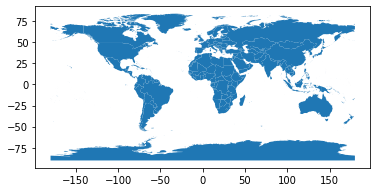

In [29]:
gdf_countries = gpd.read_file('data/countries/ne_50m_admin_0_countries.shp')

gdf_countries.plot()

<br>

We also need to convert our lightning strike data into a spatial dataframe.

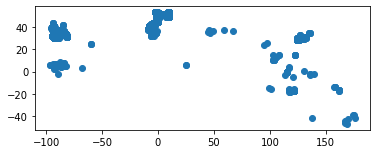

In [30]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf_strikes = gpd.GeoDataFrame(df.copy(), crs='epsg:4326', geometry=geometry)

gdf_strikes.plot()

<br>

We'll now combine the basemap and lightning strikes into a single plot

[]

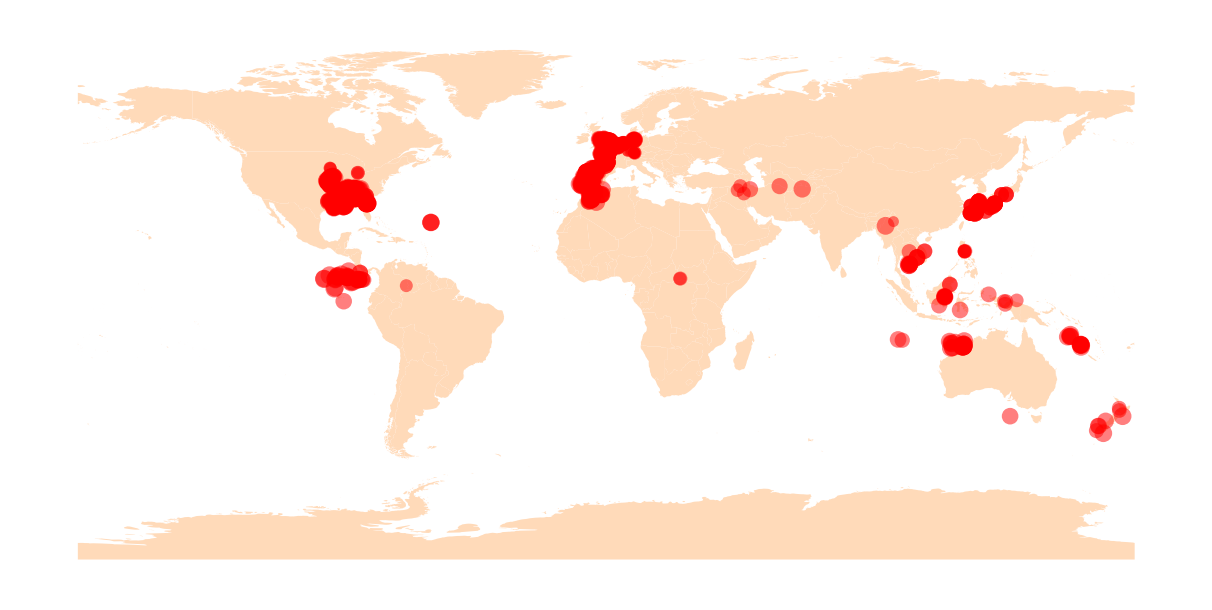

In [31]:
fig, ax = plt.subplots(dpi=250)

gdf_countries.plot(color='peachpuff', ax=ax)
gdf_strikes.plot(markersize=gdf_strikes['mcg']/10, color='red', ax=ax, alpha=0.5, linewidth=0)

hide_spines(ax,  positions=['top', 'bottom', 'left', 'right'])
ax.set_xticks([])
ax.set_yticks([])

<br>

That seems a bit basic though, we can add interactivity and custom icons through folium. We'll only plot a sample of the data though as Folium can struggle to handle large numbers of markers.

In [46]:
## Initialising map with custom tiles
m = folium.Map([0, 0], zoom_start=1, tiles='cartodbpositron')

## Plotting the strikes
for lon, lat, mcg in df[['lon', 'lat', 'mcg']].sample(100).values:
    folium.Marker(
        location=[lat, lon],
        popup=f'Maximal circular gap: {int(mcg)}',
        icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(m)

m

<br>

### Animated Data Visualisation

Next we'll look into how we can save our data as a raster and visualise lightning strikes over time in a GIF.

In [33]:
%%time
## rename as east south west north etc
lon_min = -20000000
lon_max = 20000000
lat_min = -15500000
lat_max = 18700000

resolution_factor = 100000
assert isinstance(resolution_factor, int), 'The resolution factor must be an integer'

lon_vector = np.linspace(lon_min, lon_max, 1+int((lon_max - lon_min)/resolution_factor))
lat_vector = np.linspace(lat_min, lat_max, 1+int((lat_max - lat_min)/resolution_factor))

lon_grid, lat_grid = np.meshgrid(lon_vector, lat_vector)

lon_grid.shape

Wall time: 1.99 ms


(343, 401)

In [34]:
%%time

df_grid = pd.DataFrame({'merc_lon':lon_grid.flatten(), 
                        'merc_lat':lat_grid.flatten()})

s_merc_lon_lat_pairs = df_grid.apply(tuple, axis=1)

s_merc_lon_lat_pairs.head()

Wall time: 804 ms


0    (-20000000.0, -15500000.0)
1    (-19900000.0, -15500000.0)
2    (-19800000.0, -15500000.0)
3    (-19700000.0, -15500000.0)
4    (-19600000.0, -15500000.0)
dtype: object

<br>

We'll quickly look at how the mercator projection grid appears when reprojected to latitude and longitude. We can see that towards the poles the longitude/latitude grid becomes closer, meaning that in the mercator projection those regions are stretched whilst nearer the equator the grid is compressed.

Wall time: 9.58 s


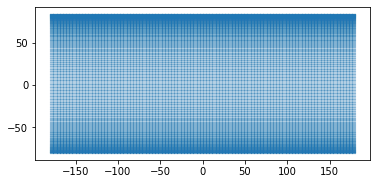

In [35]:
%%time

geometry = [Point(xy) for xy in zip(df_grid['merc_lon'], df_grid['merc_lat'])]
gs_grid = gpd.GeoSeries(geometry, crs='epsg:3395')

gs_grid_epsg4326 = gs_grid.to_crs(epsg=4326)
gs_grid_epsg4326.plot(markersize=0.01)

In [36]:
s_strikes_merc_geom = (gdf_strikes
                       .set_index('time')
                       .to_crs(epsg=3395)
                       .geometry
                      )

s_strikes_merc_geom.head()

time
2020-04-12 16:55:47.067917000    POINT (-10296841.725 3775334.097)
2020-04-12 16:55:47.067935200    POINT (-10289868.004 3777495.143)
2020-04-12 16:55:46.672405000       POINT (622015.689 6698796.429)
2020-04-12 16:55:46.673993000       POINT (625981.223 6701149.459)
2020-04-12 16:55:46.674000600       POINT (628319.155 6704281.995)
Name: geometry, dtype: geometry

In [37]:
%%time

def get_cell_value_counts(s_strikes_merc_geom, resolution_factor=100000, min_time='2020'):
    rounding_factor = int(-np.log10(resolution_factor))

    s_loc_strike_counts = (pd.DataFrame({'x':s_strikes_merc_geom[min_time:].x,
                                         'y':s_strikes_merc_geom[min_time:].y,
                                        })
                           .round(rounding_factor)
                           .apply(tuple, axis=1)
                           .value_counts()
                          )
    
    return s_loc_strike_counts

min_time = '2020-04-12 14:27:02'

s_loc_strike_counts = get_cell_value_counts(s_strikes_merc_geom, resolution_factor)

s_loc_strike_counts.head()

Wall time: 312 ms


(-9700000.0, 4000000.0)     1037
(-9800000.0, 4000000.0)      995
(100000.0, 6800000.0)        833
(-10200000.0, 3800000.0)     734
(-9900000.0, 4000000.0)      707
dtype: int64

In [38]:
%%time

def create_density_grid(s_merc_lon_lat_pairs, s_loc_strike_counts, grid_shape):
    grid_density = dict(zip(s_merc_lon_lat_pairs.values, np.zeros(s_merc_lon_lat_pairs.shape[0])))
    grid_density.update(s_loc_strike_counts.to_dict())

    s_grid_density = s_merc_lon_lat_pairs.map(grid_density)
    density_grid = s_grid_density.values.reshape(grid_shape)
    
    return density_grid

density_grid = create_density_grid(s_merc_lon_lat_pairs, s_loc_strike_counts, lon_grid.shape)

print(f'There were {int(density_grid.sum())} lightning strikes')
print(f'Grid shape: {density_grid.shape}')

density_grid

There were 10955 lightning strikes
Grid shape: (343, 401)
Wall time: 558 ms


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
affine = rio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, 
                                   density_grid.shape[1], density_grid.shape[1])

affine

Affine(99750.62344139651, 0.0, -20000000.0,
       0.0, -85286.78304239402, 18700000.0)

In [40]:
# https://epsg.io/3395

In [41]:
strike_raster = rio.open('data/test_strike_raster.tif', 'w', driver='GTiff',
                         height=density_grid.shape[0], width=density_grid.shape[1],
                         count=1, dtype=str(density_grid.dtype),
                         crs='+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',
                         transform=affine, nodata=0)

strike_raster.write(density_grid, 1)
strike_raster.close()

# Something is currently wrong with the way that the raster is plotting its likely something to do with the imshow, should look into better ways of plotting it with rasterio, check the rasterio code for show

[]

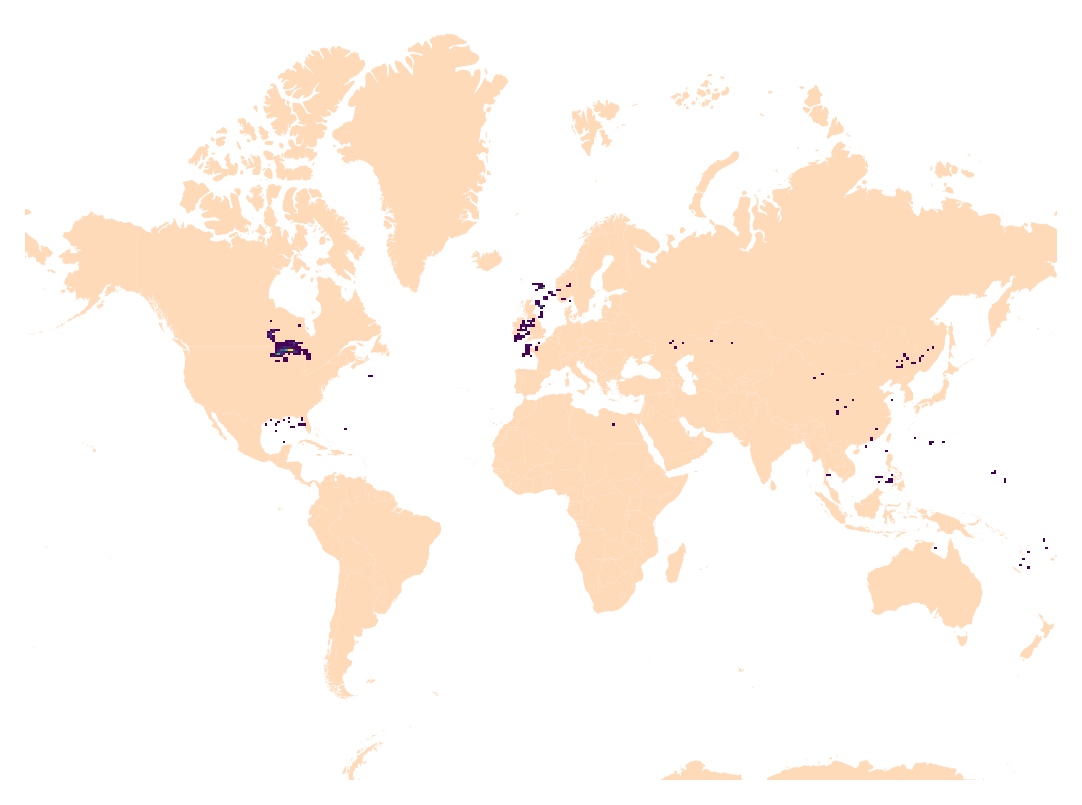

In [45]:
strike_raster = rio.open('data/test_strike_raster.tif')

## Plotting
fig, ax = plt.subplots(dpi=250)

gdf_countries.to_crs(epsg=3395).plot(color='peachpuff', ax=ax, zorder=0)
ax.imshow(strike_raster.read(masked=True)[0], zorder=1, origin='bottom', 
          extent=plotting_extent(strike_raster, strike_raster.transform))

hide_spines(ax,  positions=['top', 'bottom', 'left', 'right'])
ax.set_xticks([])
ax.set_yticks([])